In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from scipy.stats import zscore
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (roc_auc_score, 
                             precision_score, 
                             recall_score,
                             f1_score, 
                             accuracy_score, 
                             homogeneity_score, 
                             completeness_score, 
                             v_measure_score,
                             silhouette_score)
from sklearn.cluster import (KMeans, 
                             AgglomerativeClustering) # а также другие алгоритмы

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

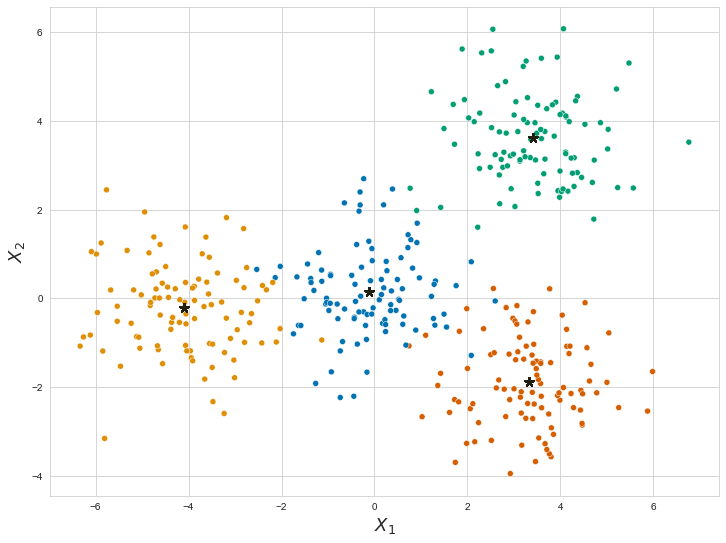

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        cluster_labels = []
        for x in X:
            label = np.sum(np.square(x - self.centroids), axis=1).argmin()
            cluster_labels.append(label)
        cluster_labels = np.array(cluster_labels)
        #dists = []
        #for centroid in self.centroids:
        #    dists.append(self._calculate_distance(X, centroid))
        #dists = np.concatenate(dists, axis=1)
            
        #cluster_labels = np.argmin(dists, axis=1) 
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        dist = np.sum(np.square(X - centroid), axis=1).reshape(-1, 1)
        #dist = np.sqrt(np.sum((X - centroid) ** 2, axis=1)).reshape(X.shape[0], 1)
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

Обучим с 4 центроидами:

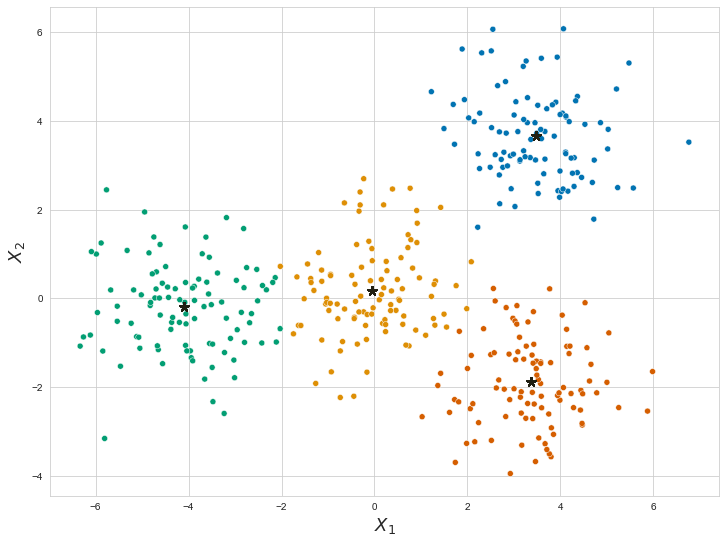

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
kmean_random = MyKMeans(n_clusters = 4, init="random", visualize=True)
kmean_random.fit(X)

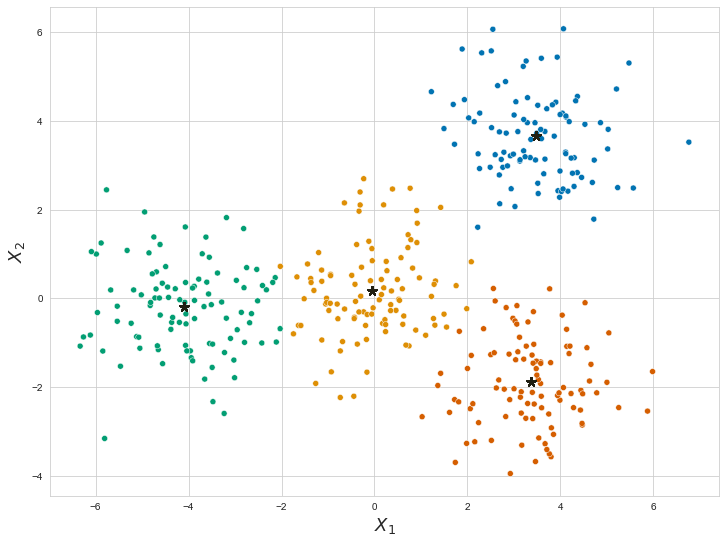

In [8]:
y_pred_random = kmean_random.predict(X)
visualize_clusters(X, y_pred_random)

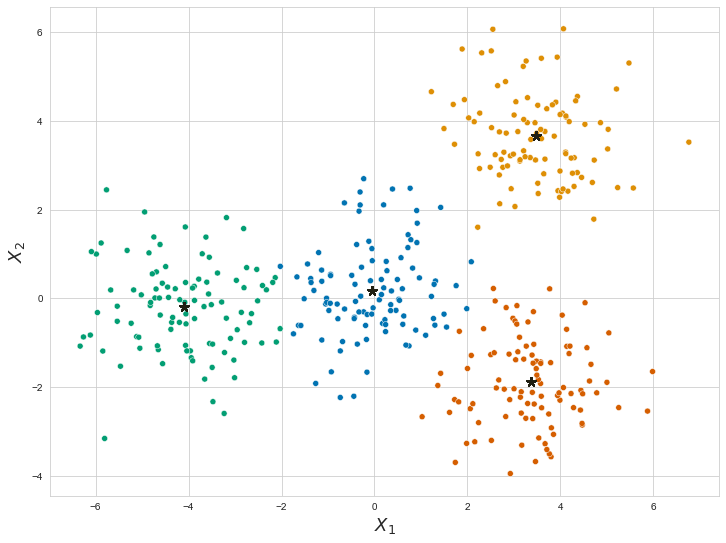

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [9]:
kmean_sample = MyKMeans(n_clusters = 4, init="sample", visualize=True)
kmean_sample.fit(X)

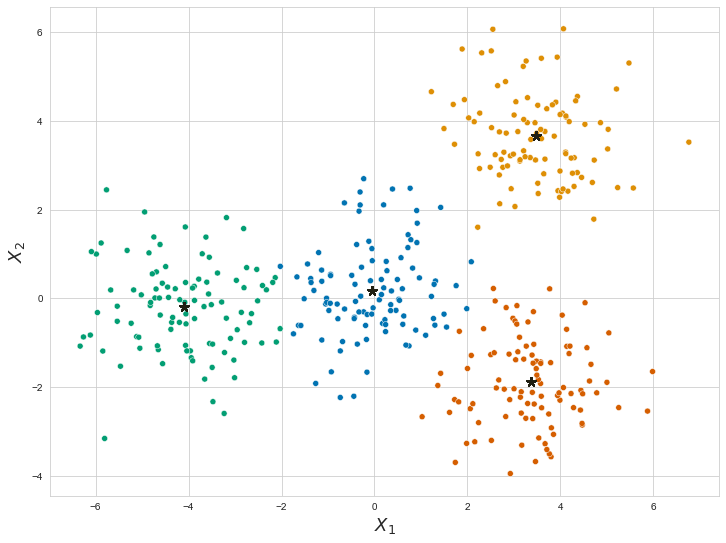

In [10]:
y_pred_sample = kmean_sample.predict(X)
visualize_clusters(X, y_pred_sample)

In [11]:
print(f'accuracy random: {round(accuracy_score(true_labels, y_pred_random), 3)}')
print(f'accuracy sample: {round(accuracy_score(true_labels, y_pred_sample), 3)}')
print(f'precision: {round(precision_score(true_labels, y_pred_random, average="weighted"), 3)}')
print(f'precision: {round(precision_score(true_labels, y_pred_sample, average="weighted"), 3)}')
print(f'recall: {round(recall_score(true_labels, y_pred_random, average="weighted"), 3)}')
print(f'recall: {round(recall_score(true_labels, y_pred_sample, average="weighted"), 3)}')
print(f'F1 score: {round(precision_score(true_labels, y_pred_random, average="weighted"), 3)}')
print(f'F1 score: {round(precision_score(true_labels, y_pred_sample, average="weighted"), 3)}')

accuracy random: 0.245
accuracy sample: 0.482
precision: 0.247
precision: 0.478
recall: 0.245
recall: 0.482
F1 score: 0.247
F1 score: 0.478


Метод sample инициацирующий центроиды от имеющихся точек лучше практически в два раза по сравнению с методом random генерирующим координаты случайно из нормального распределения.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [12]:
data = load_digits()
X, y = data.data, data.target

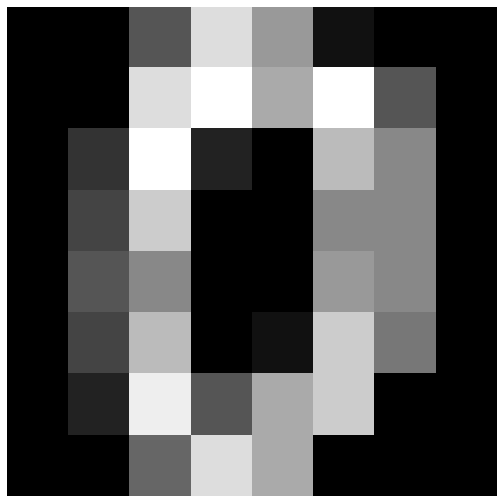

In [13]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

Как и в первой домашке посмотрим на все классы

<Figure size 864x648 with 0 Axes>

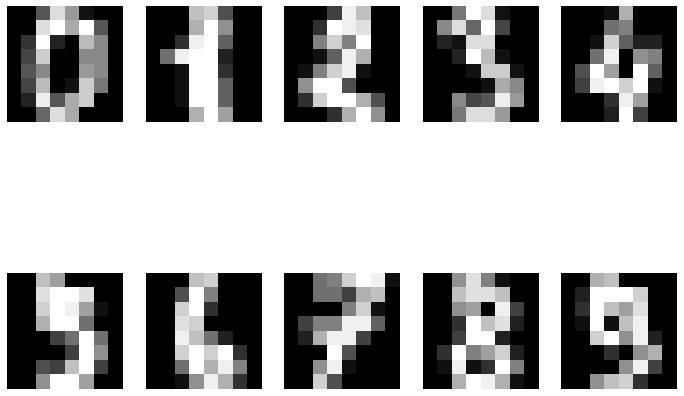

In [14]:
plt.figure()

y_class = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axes = plt.subplots(nrows = 2, ncols = 5)

for ax in axes.flatten():
    ax.axis('off')

for i in range(5):
    image = X[y_class[i]].reshape(8, 8, 1)
    axes[0,i].imshow(image, cmap="gray")

for i in range(5):
    image = X[y_class[5+i]].reshape(8, 8, 1)
    axes[1,i].imshow(image, cmap="gray")
plt.show()

Посмотрим на баланс классов

In [15]:
print('Class: frequency (%)')
(uniq, freq) = (np.unique(y, return_counts=True))
for i in range(10): print(f'{uniq[i]}: {freq[i]/10} %')

Class: frequency (%)
0: 17.8 %
1: 18.2 %
2: 17.7 %
3: 18.3 %
4: 18.1 %
5: 18.2 %
6: 18.1 %
7: 17.9 %
8: 17.4 %
9: 18.0 %


In [16]:
def algorithm_selection(X, y, distances, algorithms, metrics=None):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    clusters = 10
    output = []
    
    for distance in distances:
        for algoritm in algorithms:
            y_pred = AgglomerativeClustering(n_clusters=clusters, 
                                                 affinity=distance, 
                                                 linkage=algoritm).fit_predict(X)
    
            output.append([distance, algoritm, 
                           homogeneity_score(y, y_pred), 
                           completeness_score(y, y_pred), 
                           v_measure_score(y, y_pred), 
                           silhouette_score(X, y_pred)])
        
    compare_dataframe = pd.DataFrame(output, columns=['distance', 'linkage', 'homogenity', 
                                                      'completeness', 'v_measure', 'silhouette'])
    
    return compare_dataframe

In [17]:
distances = ['euclidean', 'manhattan', 'cosine', 'minkowski']
algorithms = ['average', 'single', 'complete']

In [18]:
algorithm_selection(X, y, distances=distances, algorithms=algorithms)

,distance,linkage,homogenity,completeness,v_measure,silhouette
0,euclidean,average,0.655393,0.782342,0.713263,0.146625
1,euclidean,single,0.005056,0.273755,0.009929,-0.133621
2,euclidean,complete,0.590549,0.637772,0.613253,0.119271
3,manhattan,average,0.566751,0.778942,0.656117,0.089217
4,manhattan,single,0.005102,0.276237,0.010019,-0.166627
5,manhattan,complete,0.646372,0.686109,0.665648,0.140183
6,cosine,average,0.648268,0.808762,0.719676,0.129526
7,cosine,single,0.005050,0.273389,0.009916,-0.158250
8,cosine,complete,0.528727,0.577415,0.551999,0.088021
9,minkowski,average,0.655393,0.782342,0.713263,0.146625


Итак, лучшая кластеризация (иерархическая) с параметрами: 
1. лучший homogenity 	= 0.655393 имеют euclidean average и minkowski average
2. лучший completeness 	= 0.808762 имеет cosine average
3. лучший v_measure 	= 0.719676 имеют cosine average 	
4. лучший silhouette 	= 0.089217 имеет manhattan average 	

В целом, по всем параметрам сравнительно более высокие значения имеет euclidean average и minkowski average

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [19]:
fc_data = pd.read_csv(join('../data/', "flow_c_data.csv"), index_col=0)
fc_data

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
0,0.722199,0.154232,0.494449,0.512853,4.057328,1.019255,4.007273,-1.406912,0.384406
1,0.751073,0.114618,4.671924,0.822042,4.933149,0.159388,-0.216407,6.034845,0.577039
2,1.108188,0.150011,-0.422857,4.006353,5.616384,0.519223,0.783077,-0.318668,-0.493832
3,0.553310,0.119929,0.345968,3.332310,5.260935,1.481229,0.264846,0.694883,3.416960
4,0.774884,0.076984,4.984963,0.885501,4.562367,0.217117,0.086279,5.563345,0.471591
...,...,...,...,...,...,...,...,...,...
9995,1.180762,0.441445,2.437344,1.526085,4.455114,4.880495,0.347480,-0.591343,2.857737
9996,0.768279,0.111863,0.812236,4.254496,5.008437,1.303261,-0.130244,0.344169,-0.626795
9997,1.314964,0.233584,4.144130,1.311947,5.340263,1.598675,-0.287353,-0.887078,4.369294
9998,0.894135,0.137300,-0.226186,0.246804,4.430212,0.457881,2.404284,-0.112999,0.069239


Основная идея проточной цитометрии -  «поштучный» анализ клеток в потоке, проходящий с большой скоростью. Благодаря эффекту гидродинамического фокусирования исследуемые клетки выстраиваются в цепочку и пересекают пучок световых лучей, служащих для анализа каждой отдельно взятой клетки.


* Детектор прямого (малоуглового) светорассеяния (forward scatter, FS) располагается по ходу лазерного луча за проточной ячейкой. Интенсивность рассеянного под малым углом света пропорциональна размеру клетки.
* Детектор бокового светорассеяния (side scatter, SS). Внутреннее содержимое клеток оптически неоднородно. Луч лазера, проходя сквозь клетку, многократно преломляется и рассеивается во все стороны. Регистрация этого бокового светорассеяния позволяет судить о сложности внутреннего строения клетки (соотношение ядро/цитоплазма, наличие гранул, других внутриклеточных включений).

Сответственно есть сигнал прямого светорассеяния (FSC, "forward scatter") от более крупных объектов и сигнал бокового светорассеяния (SSC, "side scatter") от объектов с гранулярностью (везикулы, включения).


##### YOUR TURN TO CODE:

In [20]:
print(f'{fc_data.shape[0]} образцов (=клеток) и {fc_data.shape[1]} признаков')

10000 образцов (=клеток) и 9 признаков


В данных нет пропущенных значений и они все числовые

In [21]:
fc_data.isna().sum()

FSC-A     0
SSC-A     0
HLA-DR    0
CD3       0
CD45      0
CD14      0
CD56      0
CD19      0
CD11c     0
dtype: int64

In [22]:
fc_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


Будет необходима стандартизация - среднее и стандартное отколонение отличаются.

In [23]:
fc_data.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.962458,0.165415,1.791579,3.280391,5.169845,1.097182,0.412223,1.219683,0.569898
std,0.500012,0.190773,2.027281,2.112079,0.518247,1.375876,1.176967,2.285305,1.502445
min,0.144786,0.021657,-7.634172,-2.517639,-8.329666,-8.833883,-12.358701,-9.640775,-11.085437
25%,0.798804,0.105550,0.275056,1.401943,4.922227,0.389746,-0.195978,-0.146948,-0.498781
50%,0.908574,0.130543,1.194313,4.373660,5.234119,0.672853,0.053267,0.244121,0.272297
75%,1.052034,0.162536,3.696976,4.842212,5.481218,1.065076,0.378576,0.908374,1.220576
max,42.954485,15.460997,12.946668,13.844391,13.710922,6.294236,6.461899,7.208721,6.840864


Построим распределения каждого признака и найдем очевинные выбросы (если есть)

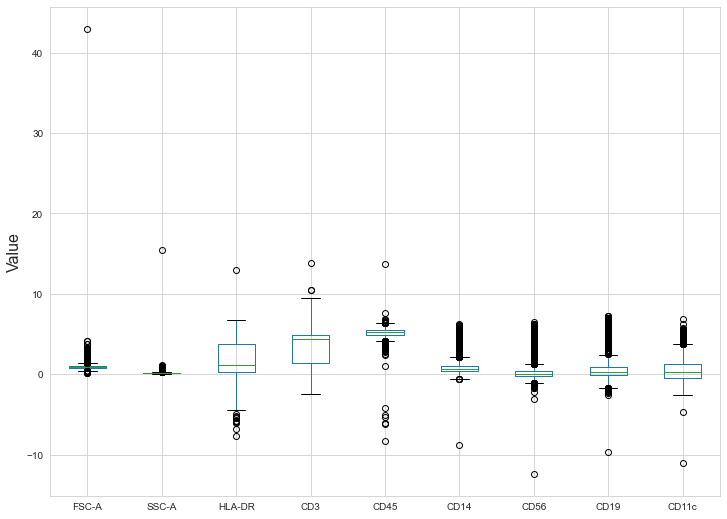

In [24]:
boxplot = fc_data.boxplot(column=list(fc_data.columns)) 
plt.ylabel('Value', fontsize=16);

Выбросы, очевидно, есть. Для того чтобы убрать их из датасета, воспользуемся порогом в 3 стандартных отклонения.

In [25]:
fc_data_outliers = fc_data[np.abs(zscore(fc_data) < 3).all(axis=1)]
fc_data_outliers.shape

(9309, 9)

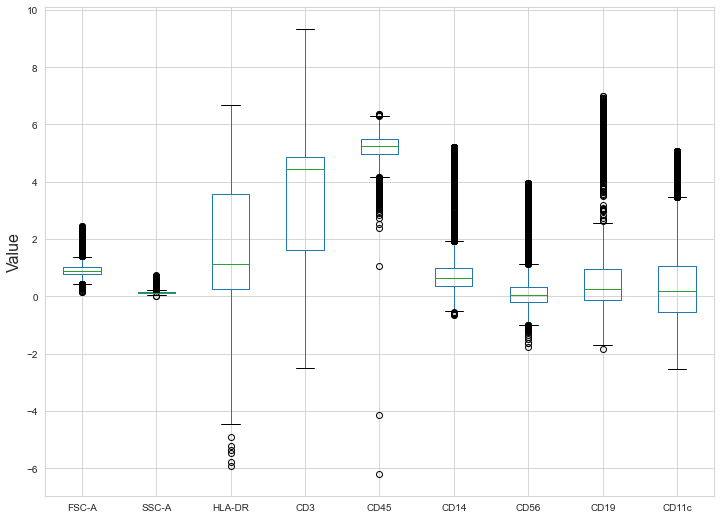

In [26]:
boxplot = fc_data_outliers.boxplot(column=list(fc_data_outliers.columns)) 
plt.ylabel('Value', fontsize=16);

Заключение: стало лучше

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [27]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

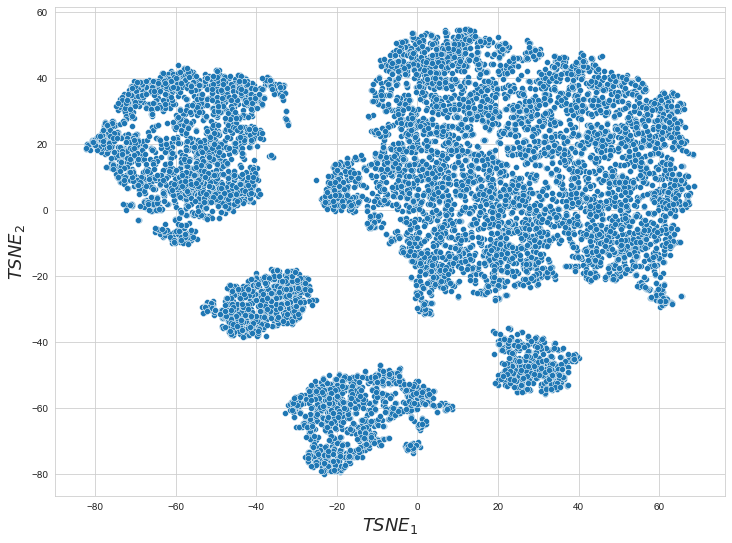

In [28]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Импользуем K-Means

In [29]:
for i in range(2, 7):
    kmeans_pred = KMeans(n_clusters=i).fit_predict(fc_data)
    print(f'Silhouette score n_clusters={i}: ' + str(round(silhouette_score(fc_data, kmeans_pred), 2)))

Silhouette score n_clusters=2: 0.54
Silhouette score n_clusters=3: 0.61
Silhouette score n_clusters=4: 0.61
Silhouette score n_clusters=5: 0.35
Silhouette score n_clusters=6: 0.36


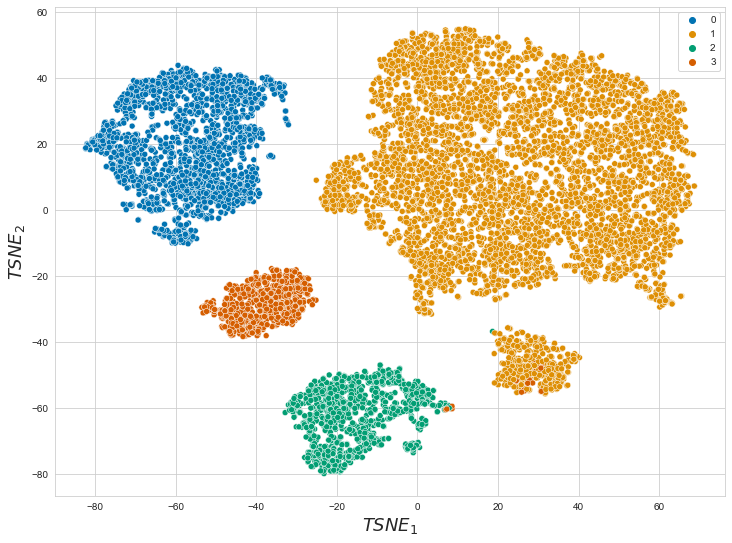

In [30]:
kmeans_pred = KMeans(n_clusters=4).fit_predict(fc_data)
kmeans_res = plot_tsne(fc_data, color=kmeans_pred)

In [31]:
silhouette_score(fc_data, kmeans_pred)

0.6103014000983125

Используем иерархическую кластеризацию (кластеры идеальнейше красятся, когда задаем трешхолд, так что сделаем это)

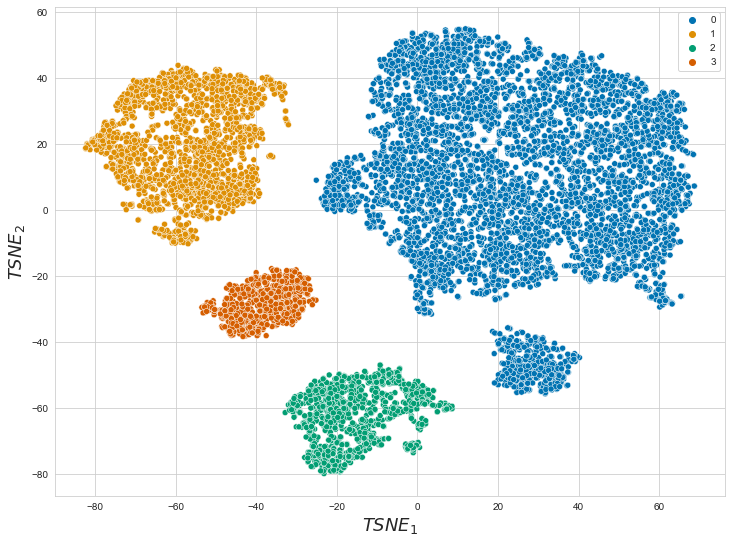

In [32]:
agglomerative_clusterer = AgglomerativeClustering(n_clusters=None, 
                                                  distance_threshold=100)
agglomerative_clusterer_results = agglomerative_clusterer.fit_predict(fc_data)
plot_tsne(fc_data, color=agglomerative_clusterer_results);

In [33]:
silhouette_score(fc_data, agglomerative_clusterer_results)

0.6114468221314616

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Da

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

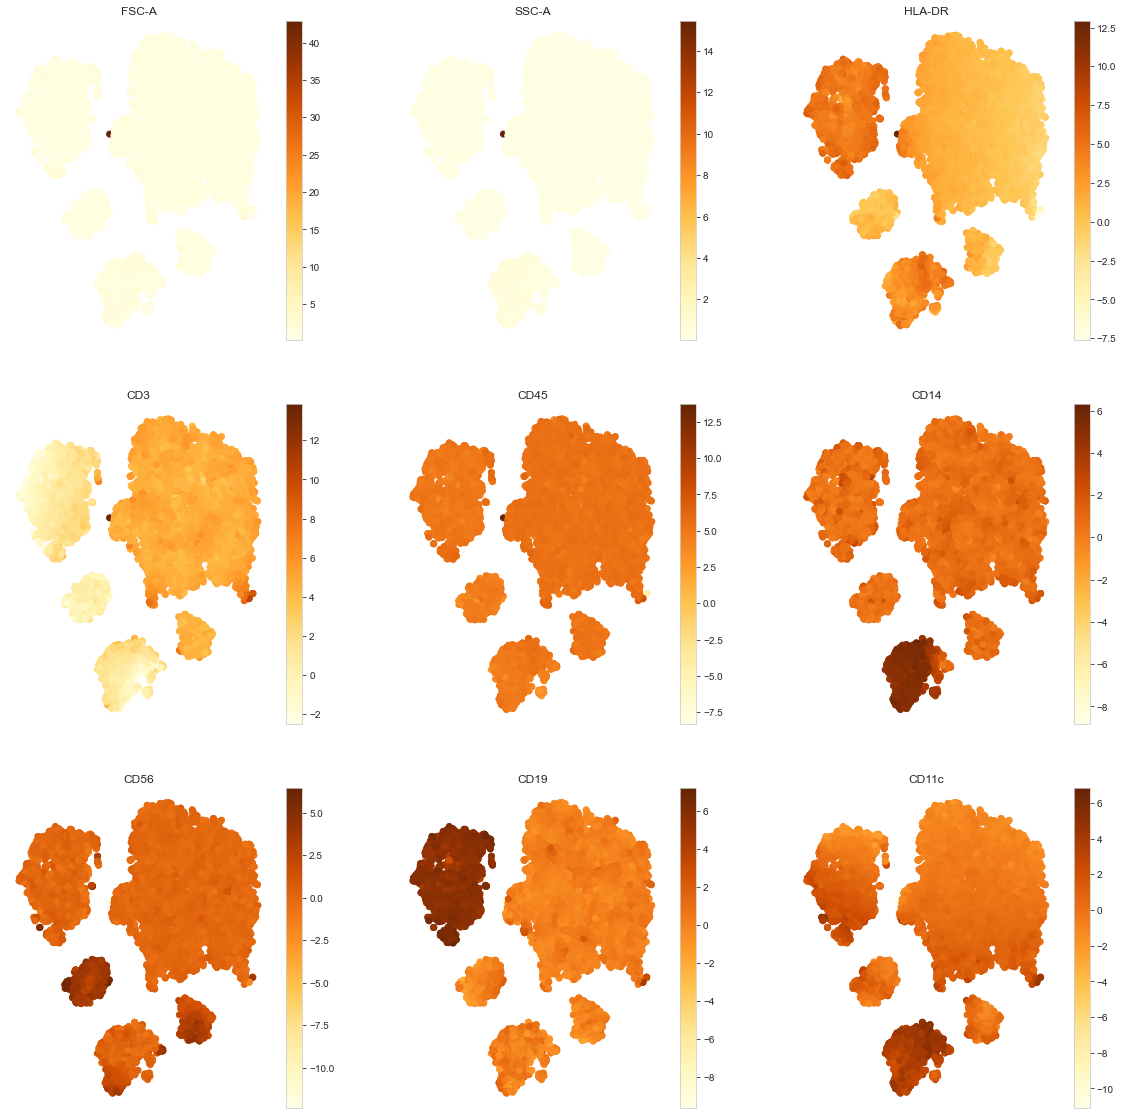

In [34]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [35]:
cell_type_cluster_map = {0: 'Other cells', 
                         1: 'B-cells', 
                         2: 'Monocytes', 
                         3: 'T-cells'}

In [36]:
labeled_fc_data = fc_data.assign(Population=agglomerative_clusterer_results)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [37]:
labeled_fc_data['Population'].value_counts()

Other cells    6231
B-cells        2035
Monocytes      1099
T-cells         635
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [38]:
population = pd.DataFrame({'Population': ['Other cells', 'B-cells', 'Monocytes', 'T-cells'], \
                                 'Number': list(labeled_fc_data['Population'].value_counts())})

population.to_csv("../data/population.csv")

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 

In [40]:
X = labeled_fc_data.drop("Population", axis=1)
y = labeled_fc_data['Population']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=SEED)

In [42]:
def find_best_k(X_train, y_train, X_test, y_test, params):
    train_metrics = []
    test_metrics = []
    
    for k in params: 
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(X_train, y_train)
        
        train_predict = knn_model.predict(X_train) 
        test_predict = knn_model.predict(X_test) 
        train_metrics.append(f1_score(y_train, train_predict, average='macro'))
        test_metrics.append(f1_score(y_test, test_predict, average='macro'))
        print(f"With k = {k} F1 for train is = {f1_score(y_train, train_predict, average='macro')}")
        print(f"With k = {k} F1 for test is = {f1_score(y_test, test_predict, average='macro')}")
        
    return train_metrics, test_metrics

In [43]:
params = [1, 5, 7, 10, 15, 25, 30, 100, 200]
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params)

With k = 1 F1 for train is = 1.0
With k = 1 F1 for test is = 1.0
With k = 5 F1 for train is = 1.0
With k = 5 F1 for test is = 1.0
With k = 7 F1 for train is = 1.0
With k = 7 F1 for test is = 1.0
With k = 10 F1 for train is = 1.0
With k = 10 F1 for test is = 1.0
With k = 15 F1 for train is = 1.0
With k = 15 F1 for test is = 1.0
With k = 25 F1 for train is = 1.0
With k = 25 F1 for test is = 1.0
With k = 30 F1 for train is = 1.0
With k = 30 F1 for test is = 1.0
With k = 100 F1 for train is = 0.9991044085454308
With k = 100 F1 for test is = 1.0
With k = 200 F1 for train is = 0.9984943981860491
With k = 200 F1 for test is = 1.0


Кажется нам подходит любой к из тех, что у нас протестированы..

Попробуем решить дисбаланс классов:
* Up-sample Minority Class для Monocytes и T-cells
* Down-sample Majority Class для Other cells

In [44]:
from sklearn.utils import resample

In [45]:
# Separate classes
df_other_cells = labeled_fc_data[labeled_fc_data['Population'] == 'Other cells']
df_b_cells = labeled_fc_data[labeled_fc_data['Population'] == 'B-cells']
df_monocytes = labeled_fc_data[labeled_fc_data['Population'] == 'Monocytes']
df_t_cells = labeled_fc_data[labeled_fc_data['Population'] == 'T-cells']

In [46]:
df_other_cells.shape

(6231, 10)

In [47]:
df_b_cells.shape

(2035, 10)

In [48]:
df_monocytes.shape

(1099, 10)

In [49]:
df_t_cells.shape

(635, 10)

Будем приводить все к набору В-клеток (2035), потому что на мой взгляд other cells слишком много, а других слишком мало.

In [50]:
# Upsample monocytes and T-cells
df_monocytes_r = resample(df_monocytes, 
                          replace=True,     # sample with replacement
                          n_samples=2035,   # to match majority class
                          random_state=123) # reproducible results

df_t_cells_r = resample(df_t_cells, 
                        replace=True,
                        n_samples=2035,
                        random_state=123)

# Downsample other cells
df_other_cells_r = resample(df_other_cells, 
                            replace=True,
                            n_samples=2035,
                            random_state=123)

In [51]:
# Combine majority class with upsampled minority class
r_df = pd.concat([df_b_cells, df_monocytes_r])
r_df = pd.concat([r_df, df_t_cells_r])
r_df = pd.concat([r_df, df_other_cells_r])

In [52]:
# Display new class counts
r_df.Population .value_counts()

B-cells        2035
Other cells    2035
Monocytes      2035
T-cells        2035
Name: Population, dtype: int64

Cool, now let's look how good it is

In [53]:
X_r = r_df.drop("Population", axis=1)
y_r = r_df['Population']

In [54]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, 
                                                            random_state=SEED)

In [55]:
params = [1, 5, 7, 10, 15, 25, 30, 100, 200]
train_metrics, test_metrics = find_best_k(X_train_r, y_train_r, X_test_r, y_test_r, params)

With k = 1 F1 for train is = 1.0
With k = 1 F1 for test is = 1.0
With k = 5 F1 for train is = 1.0
With k = 5 F1 for test is = 1.0
With k = 7 F1 for train is = 1.0
With k = 7 F1 for test is = 1.0
With k = 10 F1 for train is = 1.0
With k = 10 F1 for test is = 1.0
With k = 15 F1 for train is = 1.0
With k = 15 F1 for test is = 1.0
With k = 25 F1 for train is = 1.0
With k = 25 F1 for test is = 1.0
With k = 30 F1 for train is = 1.0
With k = 30 F1 for test is = 1.0
With k = 100 F1 for train is = 0.9996874901119919
With k = 100 F1 for test is = 0.9994249523107003
With k = 200 F1 for train is = 0.9985937333829824
With k = 200 F1 for test is = 0.998274656220294


Все еще прекрасно, единственное, не понятно почему f1_score упал, возможно все же модель стала лучше, так как у трейн и тест стали практически 

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Я хочу сходить в Cat&dog coffee (наб. реки Фонтанки, 84). Ее особенность в том, что там можно проиобрести различный авторский кофе в съедобном стаканчике. Пьешь кофе и заедашь печенькой-стаканом. Мы с моими школьными друзьями каждые полгода собираемся вместе с целью посетить эту кофейню. Так что этой весной также планируется поход))

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Все отлично, только я не совсем поняла почему послеработы с дисбалансом классов можель как будто стала хуже (хотя учитывая что это всего лишь 0,01 единиц)